# Implementation of Kohonen's self-organizing maps (SOM, Kohonen map)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from math import exp, sqrt
plt.rcParams['figure.figsize'] = (10,9)
plt.rcParams['figure.facecolor'] = (1,1,1,1)

In [2]:
class SOM():
    '''
        Naive impementation of SOM, inspired by 
        http://www.pymvpa.org/generated/mvpa2.mappers.som.SimpleSOMMapper.html
        All hyperparameters (radius, radius decay, leraning rate, learnign rate decay) are not tuned
        
    '''
    def __init__(self, shape):
        self.h, self.w = shape
        self.r = min(self.h, self.w)
        self.r_decay = None
        self.lr = 0.01
        self.lr_decay = None
        self.K = None
        self.mse = None
        self.eps = 1E-4
    def train(self, data, iterations = 100, boundary='periodic', init='pca', lr = None, lr_decay = None, r = None, r_decay = None):
        self.boundary = boundary
        if r:
            self.r = r
        decay = iterations/np.log(self.r)
        if lr:
            self.lr = lr
        if lr_decay:
            self.lr_decay = lr_decay
        else:
            self.lr_decay = np.exp(-1.0/decay)
        if r_decay:
            self.r_decay = r_decay
        else:
            self.r_decay = np.exp(-1.0/decay)
        if self.K is None:
            self.d = data.shape[1]
            #self.K = np.random.randn(self.h,self.w,self.d)
            if init == 'pca':
                from sklearn.decomposition import PCA
                pca = PCA(n_components=2, svd_solver="randomized")
                y, x, *c = np.meshgrid(np.linspace(-1,1,self.w), np.linspace(-1,1,self.h), [1])
                means = np.mean(data, axis=0, keepdims=True)
                pca.fit(data - means)
                eigvec = pca.components_
                eigval = pca.explained_variance_
                eigvec = (eigvec.T * eigval**0.5).T
                self.K = means + 2 * np.c_[x,y] @ eigvec
                #self.K = tmp.reshape((self.h, self.w, self.d))#*data.std()+data.mean()
            elif init == 'norm':
                self.K = np.random.randn(self.h,self.w,self.d)
            else: #uniform [0..1]
                self.K = np.random.random((self.h,self.w,self.d)) # kohonen layer = (defined grid x length of the input data)
                
        # precompute distance map, cartezian distance is used
        dist_map_periodic      = np.array([[sqrt((i-self.w//2)**2 + (j-self.h//2)**2) for i in range(self.w)] for j in range(self.h)])
        dist_map_nonperiodic   = np.array([[sqrt(i**2 + j**2) for i in range(-self.w,self.w)] for j in range(-self.h,self.h)])
        for _ in trange(iterations):
            # mse error on each iteration
            e = []
            for j in np.random.permutation(data.shape[0]):
                sample = data[j, :]
                # determining the BMU - best matching unit to a given input sample
                diff = sample - self.K
                d2 = (diff**2).sum(axis=-1)
                d_min = np.argmin(d2)
                d_min_x  = d_min % self.w
                d_min_y = d_min // self.w
                if boundary == 'periodic':
                    # periodic boundary conditions
                    d_map = np.roll(np.roll(dist_map_periodic, d_min_x - (self.w//2),axis=1), d_min_y - (self.h//2),axis=0)
                else:
                    d_map = dist_map_nonperiodic[self.h-d_min_y:2*self.h-d_min_y, self.w-d_min_x:2*self.w-d_min_x]
                mask = np.exp(-d_map**2/self.r**2)
                #mask[d_map > self.r] = 0
                self.K += self.lr * mask[:,:,np.newaxis] * diff
                e.append(np.min(d2))
            mse = sum(e)/len(e)/self.d    
            if self.mse is None:
                self.mse = [mse]
            elif abs(self.mse[-1] - mse)/mse < self.eps/data.shape[0]:
                break
            else:
                self.mse.append(mse)
            # squeezing of active radius and decay of the learning rate
            self.r *= self.r_decay
            self.lr *= self.lr_decay
    
    def __call__(self, data):
        '''
            Map the data onto kohonen map
            Finds the best matching unit for each data point
        '''
        out = []
        for j in range(data.shape[0]):
            sample = data[j, :]
            diff = sample - self.K
            d2 = (diff**2).sum(axis=-1)
            d_min = np.argmin(d2)
            out.append((d_min % self.w, d_min // self.w))
        return out
    
    @property
    def umatrix(self):
        '''
        naive implementation, needs to be improved
        '''
        m00 = np.roll(np.roll(self.K, 1, axis=0),1, axis=0)
        m01 = np.roll(np.roll(self.K, -1, axis=0),1, axis=0)
        m10 = np.roll(np.roll(self.K, 1, axis=0),-1, axis=0)
        m11 = np.roll(np.roll(self.K, -1, axis=0),-1, axis=0)
        d00 = np.sqrt(((m00-self.K)**2).sum(axis=2))
        d01 = np.sqrt(((m01-self.K)**2).sum(axis=2))
        d11 = np.sqrt(((m11-self.K)**2).sum(axis=2))
        d10 = np.sqrt(((m10-self.K)**2).sum(axis=2))
        u = (d00+d01+d11+d10)/4
        if self.boundary == 'periodic':
            return u
        else:
            return u[1:-1,1:-1]

## Tests

In [3]:
from matplotlib.pyplot import get_cmap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

### Colors mapping

In [25]:
'''
A list of colors (RGB) defined together with the names
The grouping of colors is studied
An axample taken from http://www.pymvpa.org/examples/som.html
'''
colors = np.array(
         [[0., 0., 0.],
          [0., 0., 1.],
          [0., 0., 0.5],
          [0.125, 0.529, 1.0],
          [0.33, 0.4, 0.67],
          [0.6, 0.5, 1.0],
          [0., 1., 0.],
          [1., 0., 0.],
          [0., 1., 1.],
          [1., 0., 1.],
          [1., 1., 0.],
          [1., 1., 1.],
          [.33, .33, .33],
          [.5, .5, .5],
          [.66, .66, .66]])

# store the names of the colors for visualization later on
color_names = \
        ['black', 'blue', 'darkblue', 'skyblue',
         'greyblue', 'lilac', 'green', 'red',
         'cyan', 'violet', 'yellow', 'white',
         'darkgrey', 'mediumgrey', 'lightgrey']

In [26]:
som = SOM((60,75))
som.train(colors, 1000, 'periodic')

100%|██████████| 1000/1000 [00:02<00:00, 353.44it/s]


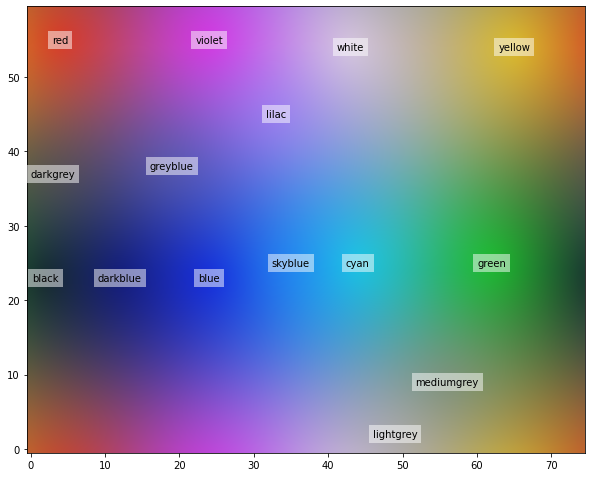

In [27]:
pts = som(colors) # map each color to its location on the map
plt.imshow(som.K, origin='lower', interpolation='spline16')
for i, pt in enumerate(pts):
    plt.text(pt[0], pt[1], color_names[i], va='center', ha='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))
#plt.savefig('som_colors_pca.png',dpi=150, bbox_inches='tight')

In [28]:
# more colors
colors = np.random.uniform(0, 1, (100, 3))
som = SOM((60,75))
som.train(colors, 1000)
#pts = som(colors) # map each color to its location on the map

100%|██████████| 1000/1000 [00:19<00:00, 51.79it/s]


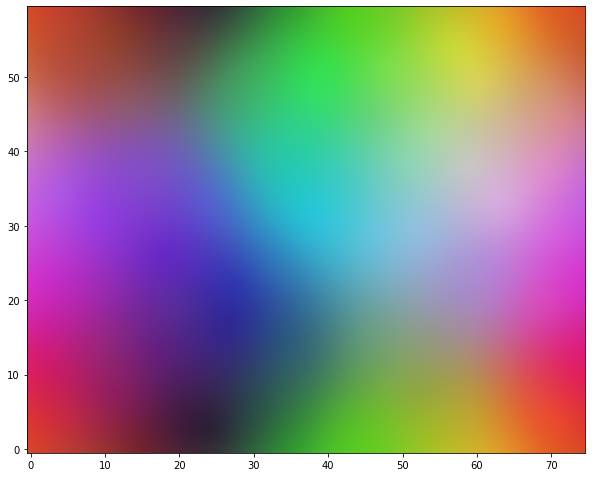

In [29]:
plt.imshow(som.K, origin='lower', interpolation='spline16')

### Test on some random data, threee groups of points on the 2D plane

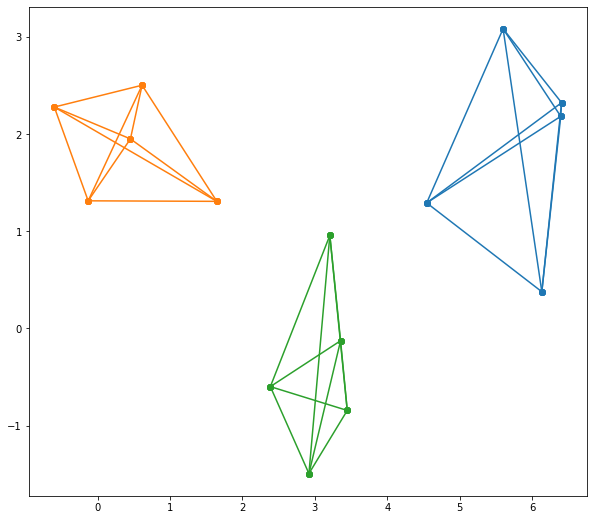

In [18]:
data = np.vstack((np.random.randn(5,2)*0.8+[6, 2], np.random.randn(5,2)*0.8+[0, 2], np.random.randn(5,2)*0.8+[3, -1]))
c = np.array([0]*5+[1]*5+[2]*5) # labels
inds = np.arange(data.shape[0])
for j in range(3):
    ind = c == j
    indx = inds[ind]
    for k in range(len(indx)-1):
        for l in range(k+1, len(indx)):
            plt.plot([data[indx[k]][0],data[indx[l]][0]], [data[indx[k]][1],data[indx[l]][1]],'o-', c=f'C{j}')

In [19]:
data = (data-data.min(axis=0))/(data.max(axis=0)-data.min(axis=0))
som = SOM((10,10))
som.train(data, 1000, 'nonperiodic')

100%|██████████| 1000/1000 [00:00<00:00, 2310.40it/s]


In [20]:
pts = som(data)

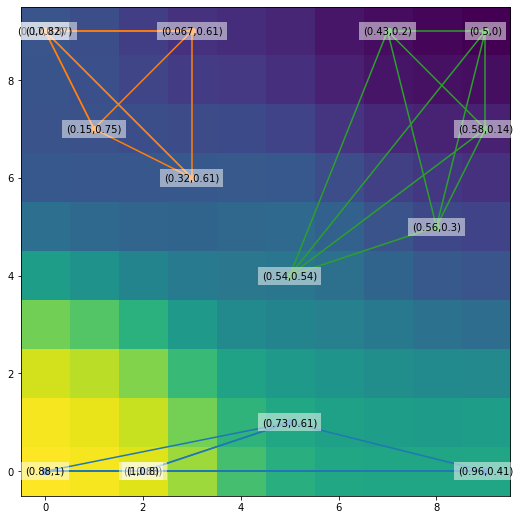

In [21]:
plt.imshow(som.K.mean(axis=2),origin='lower')
inds = np.arange(len(pts))
for j in range(3):
    ind = c == j
    indx = inds[ind]
    for k in range(len(indx)-1):
        for l in range(k+1, len(indx)):
            plt.plot([pts[indx[k]][0],pts[indx[l]][0]], [pts[indx[k]][1],pts[indx[l]][1]],'o-', c=f'C{j}')
for i, pt in enumerate(pts):
    plt.text(pt[0], pt[1], f'({data[i, 0]:1.2g},{data[i, 1]:1.2g})', va='center', ha='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))

10 10 2


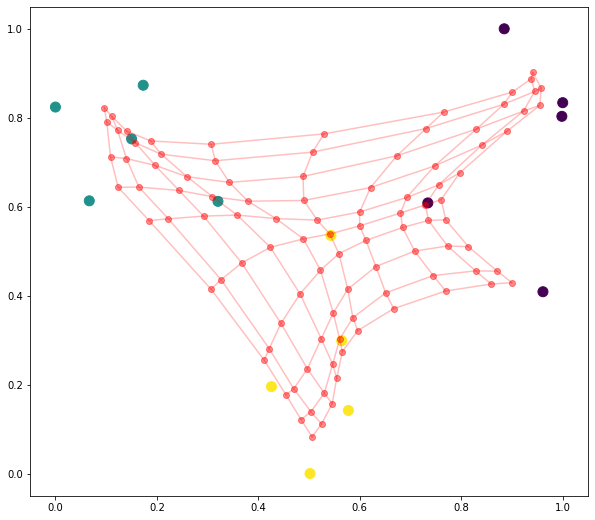

In [22]:
# making a kohonen grid
h, w, d = som.K.shape
print(h,w,d)
for i in range(0, h):
    plt.plot(som.K[i,:, 0], som.K[i,:, 1], 'ro-',alpha=0.25)
for j in range(0, w):
    plt.plot(som.K[:,j, 0], som.K[:,j, 1], 'ro-', alpha=0.25)
plt.scatter(data[:, 0], data[:, 1], c=c, s=100)
#plt.savefig('som_grid.png', dpi=150, bbox_inches='tight')

### Fancy: test on IRIS data

In [30]:
from sklearn.datasets import load_iris
iris = load_iris()
data = iris['data']
c = iris['target']
data = (data - data.mean())/data.std()
#data = (data - data.min())/(data.max()-data.min()) # Normalize data to [0,1] range

In [31]:
som = SOM((60,60))
som.train(data, 500, 'periodic')

100%|██████████| 500/500 [00:13<00:00, 37.80it/s]


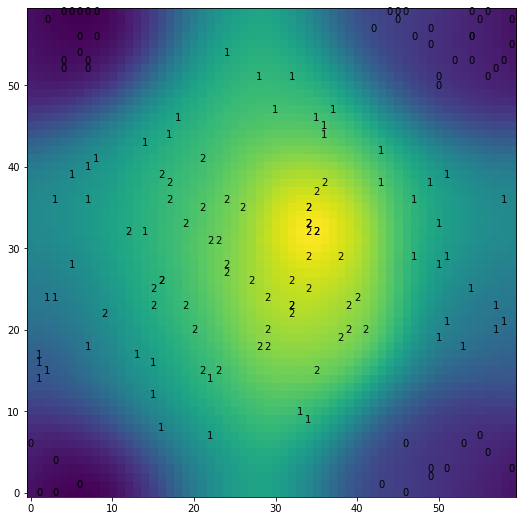

In [32]:
pts = som(data)
pts_ = np.array(pts)
plt.imshow(som.K.sum(axis=2),origin='lower')
#plt.scatter(pts_[:,0], pts_[:,1], c=c, alpha=0.25,s=50,cmap='viridis')
for i in range(len(pts)):
    plt.text(pts_[i,0], pts_[i,1],c[i], va='center',ha='center')
#plt.savefig('som_iris_pca.png',dpi=150, bbox_inches='tight')

### Test on MNIST dataset - handwritten digits

In [265]:
from sklearn import datasets
# load the digits dataset from scikit-learn
digits = datasets.load_digits(n_class=10)
data = digits.data  # matrix where each row is a vector that represent a digit.
data = data/data.max(axis=1, keepdims=True)
num = digits.target  # num[i] is the digit represented by data[i]

In [266]:
data.shape # here we have 1797 handwritten digits as 8x8 b/w images

(1797, 64)

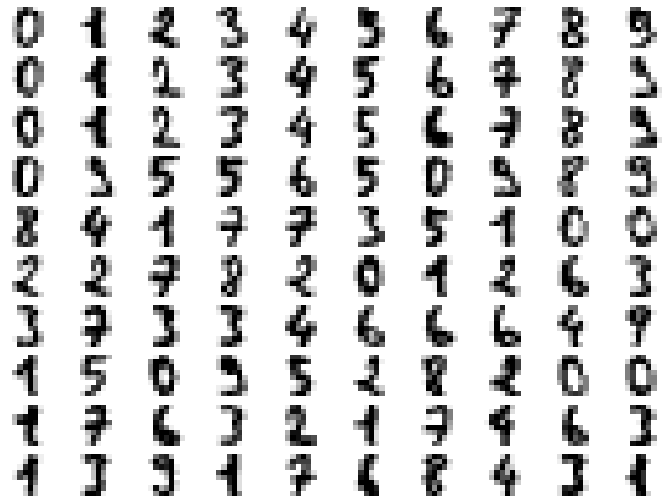

In [268]:
N = 10
for j in range(N*N):
    d = data[j, :].reshape((8,8))
    plt.subplot(N,N,j+1)
    plt.imshow(d,cmap='gray_r')#, interpolation='spline16')
    plt.axis('off')
#plt.savefig('mnist_digits_pca.png',dpi=150, bbox_inches='tight')

In [36]:
som = SOM((40,40))
som.train(data, 500, 'periodic')

100%|██████████| 500/500 [04:39<00:00,  1.79it/s]


In [37]:
pts = som(data)
pts_ = np.array(pts)
#plt.imshow(som.K.sum(axis=2),origin='lower')
pts_ = pts_ + (np.random.random(pts_.shape)-0.5)*0.95

In [38]:
from matplotlib.pyplot import get_cmap
from matplotlib.colors import ListedColormap
cmap = get_cmap('Set1',9)
cols = ListedColormap([(0,0,0,1.0), *[cmap(i) for i in range(9)]]) # We need 10 distinct colors. black + Set1

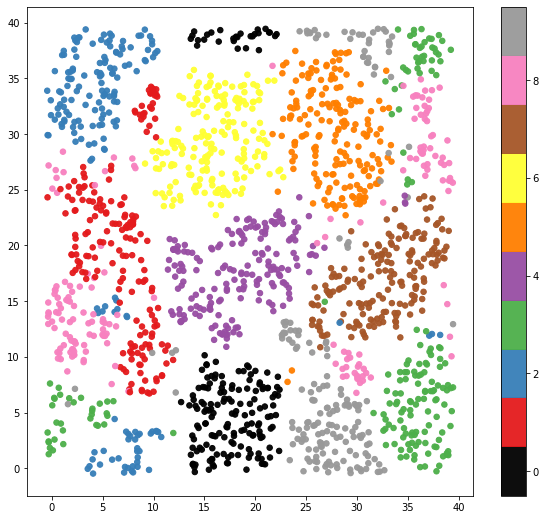

In [39]:
#plt.scatter(pts_[:,0], pts_[:,1], alpha=0.0,s=50,cmap='viridis')
plt.scatter(pts_[:,0], pts_[:,1], c=num, alpha=0.95,s=30,cmap=cols)
plt.colorbar()
plt.clim(-0.5,9.5)
'''
L = []
for i in range(len(pts)):
    d = num[i]
    if not d in L:
        plt.text(pts_[i,0], pts_[i,1],d, va='center',ha='center',fontsize=40,c=cols(d))
        L.append(d)
        if len(L) == 10:
            break
'''
plt.savefig('som_mnist_digits_pca.png',dpi=150, bbox_inches='tight')

## Test on biological data (R oposSOM sample data)

In [263]:
### Tissues (data taken from R opossom, normalized)
tmp = np.load('tissues_.npz')
data = tmp['data']
labels = tmp['labels']

In [256]:
som = SOM((20, 20))

In [258]:
som.train(data, 2000, 'nonperiodic', init='pca', lr=0.02, lr_decay = 0.999)#, r=20, lr_decay=0.999)

100%|██████████| 2000/2000 [30:03<00:00,  1.11it/s]


In [260]:
cmap2 = LinearSegmentedColormap.from_list('test', ("#00008B","#0000FF","#9AC0CD","#00CD00","#EEEE00","#EE0000","#8B0000"), 1+6*8)

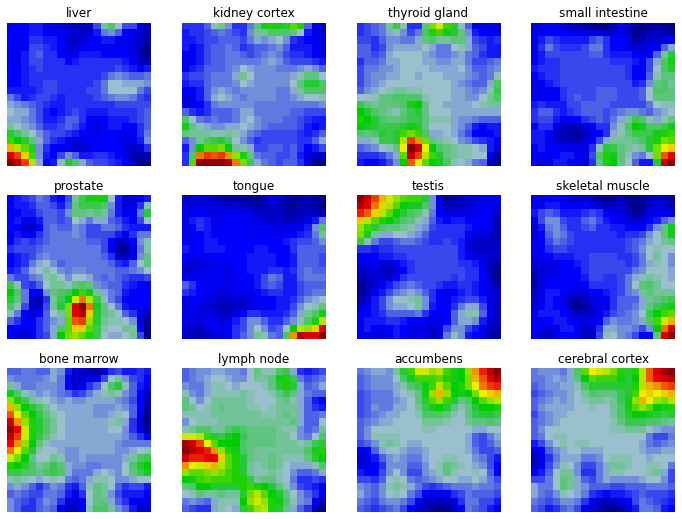

In [262]:
plt.rcParams['figure.figsize'] = (12,9)
for j in range(12):
    plt.subplot(3,4,j+1)
    plt.imshow(som.K[:,:,j], origin='lower',cmap=cmap2)#, interpolation='spline16')
    plt.axis('off')
    plt.title(labels[j])
#plt.savefig('som_tissue_portraits.png', dpi=150, bbox_inches='tight')